### This is an exploration notebook on LSTM model. Most of the code is based on Jason Browniee's [tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)  "Multivariate Time Series Forecasting with LSTMs in Keras"

In [43]:
from __future__ import print_function
import sys, time
from math import sqrt
import numpy as np
from numpy import concatenate
import matplotlib as plt
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn import preprocessing
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import LSTM,Dense,Dropout
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import plot_model


import json


In [2]:
# # load data
# def parse(x):
#     return datetime.strptime(x, '%Y %m %d %H')

# dataset = read_csv('~/Documents/TTU_study/Fall2019/my_research/neural_network/data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
# dataset.drop('No', axis=1, inplace=True)
# # manually specify column names
# dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# dataset.index.name = 'date'
# # mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)
# # drop the first 24 hours
# dataset = dataset[24:]
# # summarize first 5 rows
# print(dataset.head(5))
# save to file
# dataset.to_csv('pollution.csv')

In [3]:
# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
dataset.shape

(43800, 8)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    43800 non-null float64
dew          43800 non-null int64
temp         43800 non-null float64
press        43800 non-null float64
wnd_dir      43800 non-null object
wnd_spd      43800 non-null float64
snow         43800 non-null int64
rain         43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [6]:
values = dataset.values
print(values)

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]


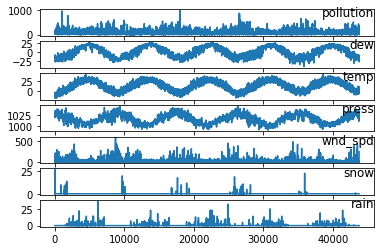

In [7]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequenceå (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg 

# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [9]:
reframed.shape

(43799, 9)

In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0619 - val_loss: 0.0517
Epoch 2/50
 - 2s - loss: 0.0384 - val_loss: 0.0362
Epoch 3/50
 - 2s - loss: 0.0186 - val_loss: 0.0207
Epoch 4/50
 - 2s - loss: 0.0165 - val_loss: 0.0165
Epoch 5/50
 - 2s - loss: 0.0157 - val_loss: 0.0149
Epoch 6/50
 - 1s - loss: 0.0155 - val_loss: 0.0143
Epoch 7/50
 - 1s - loss: 0.0154 - val_loss: 0.0144
Epoch 8/50
 - 1s - loss: 0.0152 - val_loss: 0.0143
Epoch 9/50
 - 1s - loss: 0.0151 - val_loss: 0.0139
Epoch 10/50
 - 1s - loss: 0.0148 - val_loss: 0.0135
Epoch 11/50
 - 1s - loss: 0.0151 - val_loss: 0.0136
Epoch 12/50
 - 1s - loss: 0.0149 - val_loss: 0.0135
Epoch 13/50
 - 1s - loss: 0.0150 - val_loss: 0.0134
Epoch 14/50
 - 1s - loss: 0.0148 - val_loss: 0.0135
Epoch 15/50
 - 1s - loss: 0.0148 - val_loss: 0.0134
Epoch 16/50
 - 1s - loss: 0.0148 - val_loss: 0.0135
Epoch 17/50
 - 2s - loss: 0.0147 - val_loss: 0.0136
Epoch 18/50
 - 2s - loss: 0.0148 - val_loss: 0.0136
Epoch 19/50
 - 1s - loss

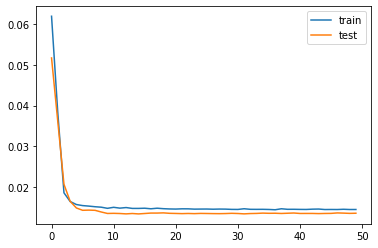

In [12]:
# design network
model = Sequential()
# First LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
model.add(LSTM(units=50, input_shape=(train_X.shape[1], train_X.shape[2]),name='LSTM1'))
# model.add(Dropout(0.2, name='dropout1'))
# # Second LSTM layer
# model.add(LSTM(units=50, return_sequences=True,name='LSTM2'))
# model.add(Dropout(0.2, name='dropout2'))
# # # Third LSTM layer
# model.add(LSTM(units=50,name='LSTM3'))
# model.add(Dropout(0.2, name='dropout3'))
# # # Fourth LSTM layer
# model.add(LSTM(units=50, name='LSTM4'))
# model.add(Dropout(0.2, name='dropout4'))
# # The output layer
model.add(Dense(units=1, name='output'))
model.compile(loss='mae', optimizer='adam')
start = time.time()

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False,
                   callbacks=[ModelCheckpoint(filepath='weights{epoch:03d}.hdf5')])
end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
test_X.shape

(35039, 1, 8)

### Evaluate Model

In [14]:
# make a prediction
yhat = model.predict(test_X)

In [15]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.683


### Extract Weights from each layer

In [16]:
# show number of layers in total
model.layers

In [17]:
def get_LSTM_UWb(weight):
    '''
    weight must be output of LSTM's layer.get_weights()
    W: weights for input
    U: weights for hidden states
    b: bias
    '''
    warr,uarr, barr = weight
    gates = ["i","f","c","o"]
    hunit = uarr.shape[0]
    U, W, b = {},{},{}
    for i1,i2 in enumerate(range(0,len(barr),hunit)):
        
        W[gates[i1]] = warr[:,i2:i2+hunit]
        U[gates[i1]] = uarr[:,i2:i2+hunit]
        b[gates[i1]] = barr[i2:i2+hunit].reshape(hunit,1)
    return(W,U,b)

def get_LSTMweights(model1):
    for layer in model1.layers:
        if "LSTM" in str(layer):
            w = layer.get_weights()
            W,U,b = get_LSTM_UWb(w)
            break
    return W,U,b
def vectorize_with_labels(W,U,b):
    bs,bs_label,ws,ws_label,us,us_label=[],[],[],[],[],[]
    for k in ["i","f","c","o"]:
        temp = list(W[k].flatten())
        ws_label.extend(["W_"+k]*len(temp))
        ws.extend(temp)

        temp = list(U[k].flatten())
        us_label.extend(["U_"+k]*len(temp))
        us.extend(temp)    

        temp = list(b[k].flatten())
        bs_label.extend(["b_"+k]*len(temp))
        bs.extend(temp)  
    weight = ws + us + bs
    wlabel = ws_label + us_label + bs_label
    return(weight,wlabel)

In [18]:
w, u, b = get_LSTMweights(model)

In [19]:
print(w, u, b)

{'i': array([[ 0.28165576,  0.3011305 ,  0.23629329,  0.03128345,  0.15857054,
         0.13673863,  0.19650477, -0.21002118,  0.01634916, -0.04646768,
        -0.12273672, -0.51207584,  0.0091824 ,  0.15810557,  0.25949913,
        -0.21279633, -0.41381973, -0.36830583,  0.30090526,  0.03682658,
         0.07699811,  0.04912456,  0.13714929,  0.09390882,  0.19087934,
        -0.40974957, -0.16801566, -0.32249498,  0.02676086,  0.13636778,
         0.23858789, -0.23539783,  0.11413895,  0.26366824, -0.2865651 ,
         0.1806866 , -0.14629203,  0.2504145 , -0.01156862,  0.17892148,
        -0.15046357, -0.04859645,  0.17209366,  0.03607015,  0.3427245 ,
        -0.02068329, -0.39403397,  0.17574795,  0.03292874,  0.30941078],
       [ 0.03934953,  0.07182664,  0.1615469 ,  0.01022553, -0.08732446,
         0.21072423,  0.08486931, -0.08922257,  0.03479234,  0.21764241,
         0.00832865,  0.04036742, -0.2795961 , -0.16959856, -0.06194479,
        -0.14868087, -0.06185969, -0.0273050

In [21]:
w.keys()

dict_keys(['i', 'f', 'c', 'o'])

In [24]:
w['i'].shape, u['i'].shape, b['i'].shape

((8, 50), (50, 50), (50, 1))

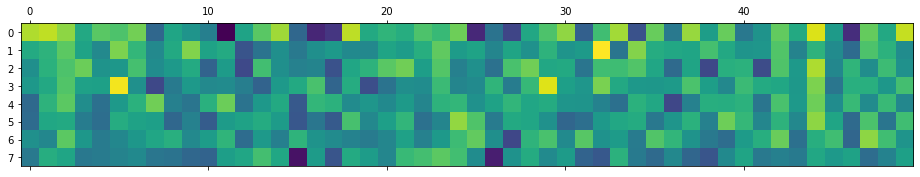

In [23]:
pyplot.matshow(w['i'])

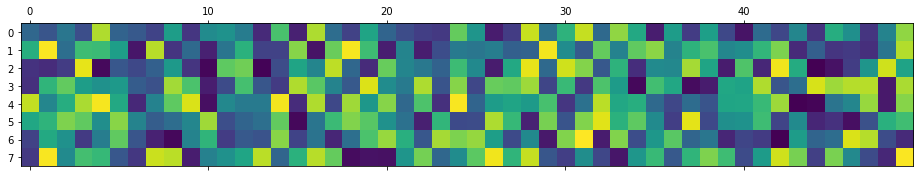

In [25]:
pyplot.matshow(w['f'])

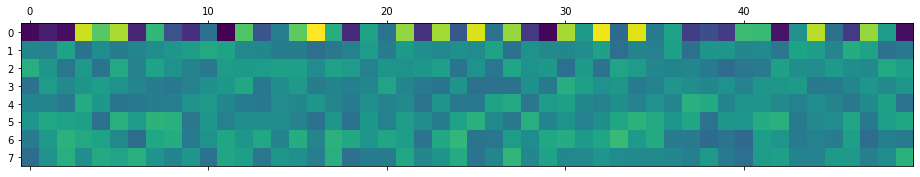

In [26]:
pyplot.matshow(w['c'])

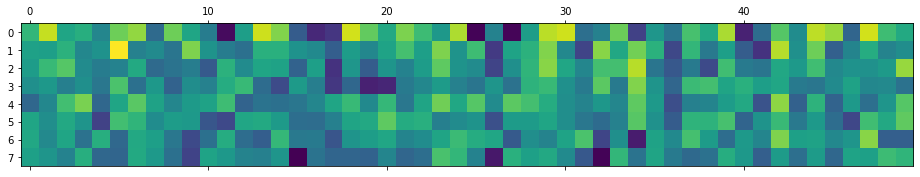

In [27]:
pyplot.matshow(w['o'])

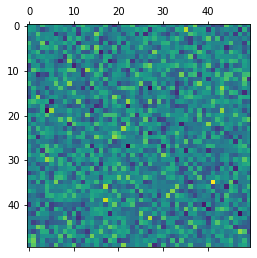

In [44]:
pyplot.matshow(u['i'])

In [230]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [234]:
with open('w_json.json', 'w') as f:
    json.dump(w,f,cls=NumpyEncoder)

In [239]:
with open('u_json.json', 'w') as f:
    json.dump(u,f,cls=NumpyEncoder)

In [240]:
with open('b_json.json', 'w') as f:
    json.dump(b,f,cls=NumpyEncoder)

In [150]:
print(vectorize_with_labels(w, u, b))

([0.03770599, -0.12887534, 0.11870693, 0.2027003, 0.2113977, -0.32453734, 0.09350206, -0.019984456, 0.083279334, -0.35647854, 0.3601595, 0.03975749, 0.39143604, 0.17912407, 0.33528614, 0.25633264, 0.14286034, 0.082683116, 0.11121658, -0.42494723, -0.12991779, 0.147481, 0.053611994, 0.21012108, 0.37975454, 0.20959483, 0.2588499, 0.17593902, -0.058568683, -0.23491435, -0.3287399, -0.22950478, -0.20313275, -0.44116685, -0.4234083, 0.013993059, -0.341671, 0.33136645, 0.27594146, 0.3834438, 0.25141102, 0.28509197, 0.28808212, 0.2670469, 0.2860142, -0.16090633, 0.36180213, 0.31477398, -0.367539, 0.39981666, 0.18717533, -0.18851212, -0.14565857, -0.10193921, -0.057632186, -0.08637117, -0.1467683, 0.12778424, 0.024176056, -0.035034068, -0.06367755, 0.033732586, -0.17834738, -0.005014539, -0.11104376, -0.03049231, 0.0052880337, -0.006921857, 0.14089423, -0.123085335, -0.06661312, 0.08711637, -0.1639481, 0.08550287, 0.12253046, 0.15474384, 0.1243871, 0.06738856, -0.022933915, -0.04954258, -0.124

In [29]:
for layer in model.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
            
warr,uarr, barr = weightLSTM

In [30]:
for e in zip(model.layers[0].trainable_weights, model.layers[0].get_weights()):
    print('Param %s:\n%s' % (e[0],e[1]))

Param <tf.Variable 'lstm_2/kernel:0' shape=(8, 200) dtype=float32, numpy=
array([[ 0.28165576,  0.3011305 ,  0.23629329, ...,  0.3473585 ,
         0.13599893,  0.06403103],
       [ 0.03934953,  0.07182664,  0.1615469 , ...,  0.07479027,
        -0.07352281, -0.03683669],
       [-0.06369504,  0.06266094,  0.13612852, ..., -0.02406355,
         0.00855772,  0.26969683],
       ...,
       [-0.19792348,  0.02345296,  0.03424115, ...,  0.13840139,
         0.06034489,  0.1947459 ],
       [-0.05979897, -0.09442699,  0.16305004, ...,  0.2507102 ,
        -0.20187844, -0.19941525],
       [-0.14928514,  0.04798561,  0.01806773, ...,  0.0304848 ,
         0.13143861,  0.10434414]], dtype=float32)>:
[[ 0.28165576  0.3011305   0.23629329 ...  0.3473585   0.13599893
   0.06403103]
 [ 0.03934953  0.07182664  0.1615469  ...  0.07479027 -0.07352281
  -0.03683669]
 [-0.06369504  0.06266094  0.13612852 ... -0.02406355  0.00855772
   0.26969683]
 ...
 [-0.19792348  0.02345296  0.03424115 ...  0.138

In [31]:
print(model.layers[0].trainable_weights)

[<tf.Variable 'lstm_2/kernel:0' shape=(8, 200) dtype=float32, numpy=
array([[ 0.28165576,  0.3011305 ,  0.23629329, ...,  0.3473585 ,
         0.13599893,  0.06403103],
       [ 0.03934953,  0.07182664,  0.1615469 , ...,  0.07479027,
        -0.07352281, -0.03683669],
       [-0.06369504,  0.06266094,  0.13612852, ..., -0.02406355,
         0.00855772,  0.26969683],
       ...,
       [-0.19792348,  0.02345296,  0.03424115, ...,  0.13840139,
         0.06034489,  0.1947459 ],
       [-0.05979897, -0.09442699,  0.16305004, ...,  0.2507102 ,
        -0.20187844, -0.19941525],
       [-0.14928514,  0.04798561,  0.01806773, ...,  0.0304848 ,
         0.13143861,  0.10434414]], dtype=float32)>, <tf.Variable 'lstm_2/recurrent_kernel:0' shape=(50, 200) dtype=float32, numpy=
array([[ 0.02564027,  0.04442084, -0.04163136, ..., -0.02897152,
         0.0354179 ,  0.08938982],
       [ 0.04939116,  0.03353401, -0.02540813, ..., -0.09469524,
         0.03650653, -0.0178205 ],
       [ 0.00312078, -

In [32]:
weightLSTM[0].shape

(50, 200)

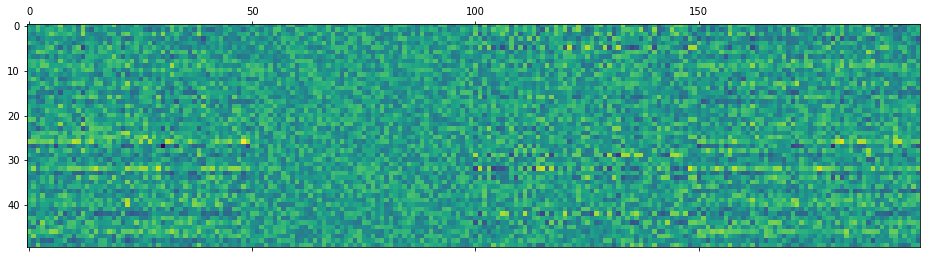

In [41]:
pyplot.matshow(weightLSTM[0])

In [34]:
units = int(int(model.layers[0].trainable_weights[0].shape[1])/4)
print("Number of units: ", units)

Number of units:  50


In [16]:
warr

array([[-0.18626894,  0.19249295,  0.15482362, ..., -0.29079497,
        -0.07477473,  0.09991136],
       [ 0.00701329, -0.11079838,  0.25785068, ..., -0.11927182,
        -0.08018969,  0.00384935],
       [ 0.00394488,  0.05737585,  0.08824104, ..., -0.01611165,
        -0.1293585 , -0.16683598],
       ...,
       [ 0.08345097,  0.06323992, -0.02342468, ...,  0.05075768,
         0.02797006, -0.03484445],
       [-0.17440316, -0.31443012,  0.12119955, ...,  0.16552442,
        -0.2860983 ,  0.00608982],
       [-0.14033882, -0.02888553,  0.12660784, ..., -0.02183752,
        -0.18639489,  0.08555061]], dtype=float32)

In [17]:
# numpy array of weights for inputs
warr.shape

(8, 200)

In [56]:
# numpy array of weights for hidden units
uarr.shape

(50, 200)

In [58]:
# numpy array of bias
barr.shape

(200,)

In [20]:
W_i = warr[:, :units]
W_f = warr[:, units: units * 2]
W_c = warr[:, units * 2: units * 3]
W_o = warr[:, units * 3:]

U_i = uarr[:, :units]
U_f = uarr[:, units: units * 2]
U_c = uarr[:, units * 2: units * 3]
U_o = uarr[:, units * 3:]

b_i = barr[:units]
b_f = barr[units: units * 2]
b_c = barr[units * 2: units * 3]
b_o = barr[units * 3:]

In [139]:
W_i

array([[-1.86268941e-01,  1.92492947e-01,  1.54823616e-01,
         1.47714883e-01,  2.32924253e-01,  2.32970610e-01,
         3.51106375e-01, -5.24536788e-01,  3.71513546e-01,
        -1.36730056e-02,  3.20056409e-01, -4.56064671e-01,
         9.50281974e-03,  3.84913720e-02, -1.88970163e-01,
        -1.77615687e-01,  2.99536645e-01,  1.04423858e-01,
         3.65457892e-01, -1.56259954e-01,  2.42083937e-01,
        -3.87618601e-01,  2.65546799e-01,  4.36148465e-01,
         2.14797050e-01,  2.30665788e-01,  1.35414869e-01,
         8.23504999e-02,  6.32659942e-02, -2.77540416e-01,
        -7.31191225e-03,  2.48201668e-01, -5.30372202e-01,
         2.91464984e-01,  1.45387113e-01, -8.39516744e-02,
         1.61313385e-01, -2.54024535e-01,  3.31468701e-01,
         1.72934711e-01, -3.30409378e-01, -1.97524428e-01,
         3.46208423e-01,  2.96556443e-01, -2.61844039e-01,
         2.83265114e-01, -1.44254729e-01, -3.35543215e-01,
        -5.19463094e-04,  3.22492480e-01],
       [ 7.01

In [25]:
W_f

array([[-0.0326784 , -0.11206256, -0.08930601,  0.00807495, -0.12328121,
        -0.02873524, -0.146687  ,  0.1313648 , -0.07148629,  0.11914331,
        -0.06423166, -0.09363738, -0.1503155 , -0.01101676, -0.01993275,
        -0.16834852, -0.04972494,  0.07113938,  0.16332981,  0.14085972,
         0.0586886 ,  0.05558774, -0.00893952,  0.00192125,  0.10165098,
        -0.09588902,  0.05979098, -0.1049346 ,  0.14344466,  0.08338723,
         0.11655551,  0.07670653, -0.06718776,  0.12296954, -0.03966112,
         0.0552478 ,  0.10168442,  0.14160234, -0.04648746,  0.07491077,
        -0.08422725,  0.10541874, -0.14707828,  0.05740273, -0.00382569,
        -0.04681493,  0.11132777,  0.08065784,  0.05609819, -0.05351334],
       [ 0.06925948, -0.07388228,  0.16548061, -0.14888251,  0.02390531,
        -0.06452754, -0.00104561, -0.04777434, -0.15213048, -0.01447181,
        -0.01508038, -0.033811  , -0.15955433, -0.07699509,  0.02580833,
         0.01667857, -0.05950357,  0.11874944,  0.

In [35]:
model.layers

In [157]:
for i, layer in enumerate(model.layers):
    print(layer.name  + ':\n', layer.get_weights())

lstm_15:
 [array([[ 0.03770599, -0.12887534,  0.11870693, ...,  0.25517443,
        -0.6334162 ,  0.13744082],
       [ 0.18717533, -0.18851212, -0.14565857, ...,  0.120162  ,
         0.23807193,  0.0070678 ],
       [ 0.08569767, -0.12592244, -0.05013337, ...,  0.1660492 ,
        -0.14279826, -0.1397172 ],
       ...,
       [ 0.11446242, -0.1593909 ,  0.07374702, ..., -0.226427  ,
        -0.10954243,  0.09925266],
       [-0.12104774, -0.12592447, -0.03560159, ..., -0.12030452,
        -0.05457432,  0.02584912],
       [-0.0867271 , -0.06507534, -0.07217237, ...,  0.00539377,
         0.09300293,  0.00104663]], dtype=float32), array([[ 0.01859575, -0.08479725,  0.02985978, ...,  0.03756055,
        -0.04800738,  0.08102772],
       [-0.05978443, -0.04457936,  0.05364292, ...,  0.09175227,
        -0.11169744,  0.02272059],
       [ 0.06112446, -0.04541477, -0.02171044, ...,  0.05112544,
         0.00964109,  0.01455254],
       ...,
       [ 0.14142384, -0.070978  , -0.13687453, .

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             11800     
_________________________________________________________________
LSTM1 (LSTM)                 (None, 50)                20200     
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 32,051
Trainable params: 32,051
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.save('lstm_model.h5')
del model
model = load_model('lstm_model.h5')

In [164]:
model.layers

In [165]:
json_string = model.to_json()

In [166]:
json_string

'{"class_name": "Sequential", "config": {"name": "sequential_53", "layers": [{"class_name": "LSTM", "config": {"name": "lstm_15", "trainable": true, "batch_input_shape": [null, 1, 8], "dtype": "float32", "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 50, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 2}}, {"class_name": 

In [167]:
# model.save_weights('lstm_weights.h5')

In [244]:
model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 1, 50)             11800     
_________________________________________________________________
dense_18 (Dense)             (None, 1, 1)              51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [37]:
def get_n_layer_output(model, n):
    return K.function([model.layers[0].input],[model.layers[n].output])
    

In [169]:
get_n_layer_output(model, 1)

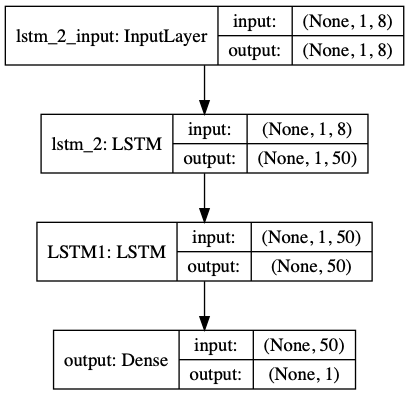

In [38]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [39]:
from copy import copy
df = {}
for epoch in np.arange(0,50,1):
    model.load_weights("weights{:03d}.hdf5".format(epoch+1))
    WUb = get_LSTMweights(model)
    weight,wlabel = vectorize_with_labels(*WUb)
    df["{:03d}".format(epoch)] = copy(weight)

df = pd.DataFrame(df,index=wlabel)
df = df[np.sort(df.columns)]

plt.figure(figsize=(15,15))
sns.heatmap(df)
plt.xlabel('epoch')
plt.show()

TypeError: 'module' object is not callable